In [1]:
from surprisal import AutoHuggingFaceModel
from collections import Counter
from wordfreq import word_frequency
from wordfreq import zipf_frequency

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import replicate
import tqdm
import time
import string


warnings.filterwarnings('ignore')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/mingyu/opt/anaconda3/envs/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ls 

README.md            data/                project_torch.ipynb


# Replicate API

Minigpt-4 is hosted on [replicate](https://replicate.com/daanelson/minigpt-4/versions/b96a2f33cc8e4b0aa23eacfce731b9c41a7d9466d9ed4e167375587b54db9423), with an API available for deployment.

| Parameter          | Interpretation                                                                                                                        | Default | Min  | Max |
|--------------------|---------------------------------------------------------------------------------------------------------------------------------------|---------|------|-----|
| num_beams          | number of beams for beam search decoding                                                                                              | 3       | 1    | 10  |
| temperature        | temperature for generating tokens, lower = more predictable results                                                                   | 1    | 0.01 | 2   |
| top_p              | sample from the top p percent most likely tokens                                                                                      | 0.9     | 0    | 1   |
| repetition_penalty | penalty for repeated words in generated text; 1 is no penalty, values greater than 1 discourage repetition, less than 1 encourage it. | 1       | 0.01 | 5   |
| max_new_tokens     | maximum number of new tokens to generate                                                                                              | 3000    | 1    |     |
| max_length         | total length of prompt and output in tokens                                                                                           | 4000    | 1    |     |                                                                                             

In [5]:
cred_path = "../../../Desktop/others/anlp_project/credential.txt"
image_path = "data/pic.png"

In [6]:
with open(cred_path, encoding = 'utf-8') as f:
  key = f.readline().strip()

os.environ["REPLICATE_API_TOKEN"] = key

# Retrieve descriptions from MiniGPT-4

In [5]:
def get_description(iteration, beams, temp, top_p, repetition):
  col = []
  val = []

  prompt = "Please tell me everything you see going on in this picture."

  for i in np.arange(0, iteration, 1):
    col.append(i)
    output = replicate.run("daanelson/minigpt-4:b96a2f33cc8e4b0aa23eacfce731b9c41a7d9466d9ed4e167375587b54db9423",
                           input={"image": open(image_path, "rb"),
                                  "prompt": prompt,
                                  "num_beams": beams,
                                  "temperature": temp,
                                  "repetition_penalty": repetition})
    val.append(output)

  data = {"iteration" : col,
          "num_beam" : [beams] * len(col),
          "temperature" : [temp] * len(col),
          "top_p" : [top_p] * len(col),
          "description": val
      }

  df = pd.DataFrame(data)

  return df

In [6]:
def get_description_df(param_list, iteration, beams, top_p, repetition):
  df = pd.DataFrame()
  for i in tqdm(param_list):
    #df = df.extend(get_description(iteration, beams, i, top_p, repetition))
    new = get_description(iteration, beams, i, top_p, repetition)
    df = pd.concat([df, new])
  df = df.reset_index(drop=True)

  return df

In [29]:
df_continue = get_description_df(param_list = np.arange(0.01, 2.01, 0.01),
                   iteration = 1,
                   beams = 1,
                   top_p = 0.9,
                   repetition = 1)

100%|██████████| 200/200 [33:08<00:00,  9.94s/it] 


In [31]:
df_continue.to_pickle('df1031.pkl')

# Text analysis

## Viz setting

In [51]:
# color_pal = ["#eb8034", "#febf98", "#f1f1f1", "#96c09b", "#338f4a"]
sns.set_style("white")
# color_pal = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#ffbcaf', '#f4777f', '#cf3759', '#93003a']
color_pal = ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', '#f4d9bc', '#e7b299', '#d98c79', '#da5372']
# color_pal = ["#157361", "#91b8ad", "#ffffff", "#ffb68c", "#f56b16"]
sns.set_palette(color_pal)
sns.color_palette(color_pal)

[(0.0, 0.25882352941176473, 0.615686274509804),
 (0.2784313725490196, 0.44313725490196076, 0.6980392156862745),
 (0.45098039215686275, 0.6352941176470588, 0.7764705882352941),
 (0.6470588235294118, 0.8352941176470589, 0.8470588235294118),
 (1.0, 1.0, 0.8784313725490196),
 (0.9568627450980393, 0.8509803921568627, 0.7372549019607844),
 (0.9058823529411765, 0.6980392156862745, 0.6),
 (0.8509803921568627, 0.5490196078431373, 0.4745098039215686),
 (0.8549019607843137, 0.3254901960784314, 0.4470588235294118)]

## Lexical analysis

In [4]:
# remove punct and tokenize
def tokenize(sent):
    return [w.strip(string.punctuation) for w in sent.lower().split()]

In [5]:
# token-type ratio
def word_counts(sent):
    counts = Counter()
    tokens = tokenize(sent)
    for token in tokens:
        counts[token] += 1
    #return counts, len(counts), sum(counts.values()), len(counts)/sum(counts.values())
    return len(counts)/sum(counts.values())

In [6]:
# average word frequency
# https://pypi.org/project/wordfreq/
def avg_word_freq(sent):
    tokens = tokenize(sent)
    
    freqs = [zipf_frequency(token, 'en', wordlist='large', minimum=-1) for token in tokens]
    # skip token not found
    avg_freq = np.mean([freq for freq in freqs if freq != -1])

    # if -1 in freqs:
    #     return 'NA in list'
    # else:
    #     return np.mean(freqs)

    return avg_freq

In [7]:
# get surprisal for each word
m = AutoHuggingFaceModel.from_pretrained('gpt2')

def get_word_surp(sent):
    # words = []
    # surps = []
    words = [word for word, surp in m.surprise(sent)[0]]
    surps = [surp for word, surp in m.surprise(sent)[0]]
    
    return pd.Series([words, surps])

### MiniGPT-4

In [86]:
df = pd.read_pickle("data/minigpt_temp_1031.pkl")
df['id'] = df.index + 1
df['model'] = ['MiniGPT-4'] * df.shape[0]
df.head()

In [ ]:
# test = df['description'][198]
# print(test)
# tokenize(test)

In [13]:
df['ttr'] = df['description'].apply(word_counts)
df['avg_freq'] = df['description'].apply(avg_word_freq)
df.head()

,iteration,num_beam,temperature,top_p,description,id,model,ttr,avg_freq
0,0,1,0.01,0.9,The image shows a woman and two children stand...,1,MiniGPT-4,0.528736,6.105172
1,0,1,0.02,0.9,The image shows a woman and two children stand...,2,MiniGPT-4,0.528736,6.105172
2,0,1,0.03,0.9,The image shows a woman and two children stand...,3,MiniGPT-4,0.478261,6.059855
3,0,1,0.04,0.9,The image shows a woman and two children stand...,4,MiniGPT-4,0.528736,6.105172
4,0,1,0.05,0.9,The image shows a woman and two children stand...,5,MiniGPT-4,0.455556,6.124889


In [85]:
# for i in df.loc[df['uid'] > 7]['description']:
#     print(i)
#     print("")

In [93]:
df[['words', 'surps']] = df['description'].apply(get_word_surp)
df['uid'] = df['surps'].apply(np.var)
df['avg_info'] = df['surps'].apply(np.mean)

In [ ]:
# df.iloc[198,:]['words']

In [15]:
df.uid.describe()

count    200.000000
mean       4.832920
std        1.420015
min        2.697915
25%        3.861651
50%        4.500088
75%        5.169777
max       11.647113
Name: uid, dtype: float64

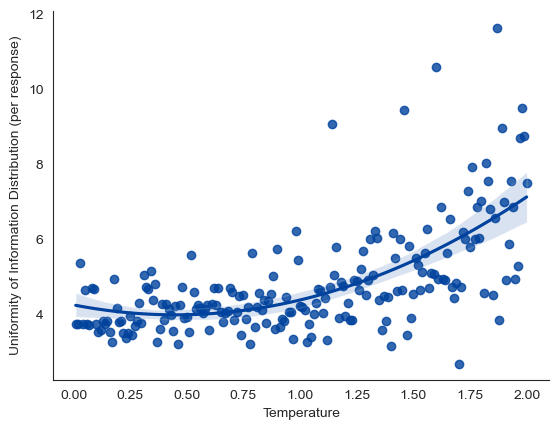

In [100]:
sns.regplot(data=df, x="temperature", y="uid", order=2)
sns.despine()
plt.xlabel("Temperature")
plt.ylabel("Uniformity of Information Distribution (per response)");
plt.savefig('minigpt-temp-scatter.png')

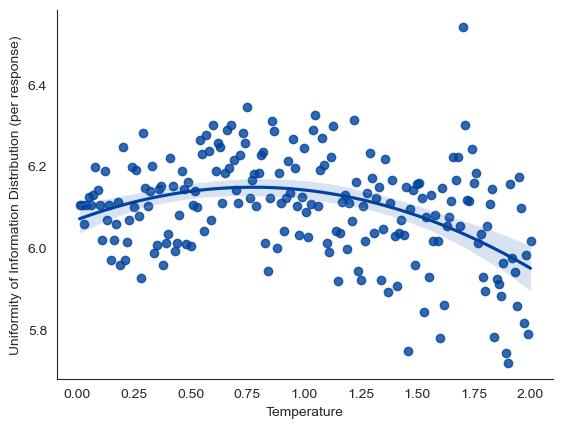

In [64]:
sns.regplot(data=df, x="temperature", y="avg_freq", order=2)
sns.despine()
plt.xlabel("Temperature")
plt.ylabel("Uniformity of Information Distribution (per response)");

In [95]:
df.to_pickle("data/minigpt_temp_1102.pkl")

#### Utterance-level

In [58]:
df['sentences'] = df['description'].str.split('.')
df

,iteration,num_beam,temperature,top_p,description,id,sentences
0,0,1,0.01,1,The image shows a woman and two children stand...,1,[The image shows a woman and two children stan...
1,0,1,0.02,1,The image shows a woman and two children stand...,2,[The image shows a woman and two children stan...
2,0,1,0.03,1,The image shows a woman and two children stand...,3,[The image shows a woman and two children stan...
3,0,1,0.04,1,The image shows a woman and two children stand...,4,[The image shows a woman and two children stan...
4,0,1,0.05,1,The image shows a woman and two children stand...,5,[The image shows a woman and two children stan...
...,...,...,...,...,...,...,...
95,0,1,0.96,1,The image shows two women and a child in a kit...,96,[The image shows two women and a child in a ki...
96,0,1,0.97,1,The image shows a woman and two children in a ...,97,[The image shows a woman and two children in a...
97,0,1,0.98,1,"A mother is standing at a sink, washing her ha...",98,"[A mother is standing at a sink, washing her h..."
98,0,1,0.99,1,This is a black and white image of a woman and...,99,[This is a black and white image of a woman an...


In [59]:
df.iloc[99,:]['sentences']

['This is a black and white image of a woman and two children standing in a kitchen',
 ' The woman is wearing a black dress and apron, and is holding a mop and bucket in her hands',
 ' The children are wearing overalls and are standing next to the woman',
 ' One of the children is reaching up to touch a cabinet above the sink, while the other is standing on a stool next to the sink, looking into the cabinet',
 ' There is a window behind the woman and children, and the room appears to be brightly lit',
 ' The walls and floor are made of white tile, and there is a counter with a sink on one side of the room',
 '']

In [60]:
fulldf = df.explode('sentences').reset_index(drop=True)
fulldf

,iteration,num_beam,temperature,top_p,description,id,sentences
0,0,1,0.01,1,The image shows a woman and two children stand...,1,The image shows a woman and two children stand...
1,0,1,0.01,1,The image shows a woman and two children stand...,1,"The woman is holding a mop and bucket, and th..."
2,0,1,0.01,1,The image shows a woman and two children stand...,1,The sink is full of dirty dishes and there is...
3,0,1,0.01,1,The image shows a woman and two children stand...,1,The walls and countertops are dirty and there...
4,0,1,0.01,1,The image shows a woman and two children stand...,1,The floor is also dirty and there is a trash ...
...,...,...,...,...,...,...,...
541,0,1,1.00,1,This is a black and white image of a woman and...,100,The children are wearing overalls and are sta...
542,0,1,1.00,1,This is a black and white image of a woman and...,100,One of the children is reaching up to touch a...
543,0,1,1.00,1,This is a black and white image of a woman and...,100,There is a window behind the woman and childr...
544,0,1,1.00,1,This is a black and white image of a woman and...,100,"The walls and floor are made of white tile, a..."


In [61]:
fulldf.iloc[545,:]

iteration                                                      0
num_beam                                                       1
temperature                                                  1.0
top_p                                                          1
description    This is a black and white image of a woman and...
id                                                           100
sentences                                                       
Name: 545, dtype: object

In [62]:
fulldf = fulldf.loc[fulldf['sentences'] != ''].reset_index(drop=True)
fulldf

,iteration,num_beam,temperature,top_p,description,id,sentences
0,0,1,0.01,1,The image shows a woman and two children stand...,1,The image shows a woman and two children stand...
1,0,1,0.01,1,The image shows a woman and two children stand...,1,"The woman is holding a mop and bucket, and th..."
2,0,1,0.01,1,The image shows a woman and two children stand...,1,The sink is full of dirty dishes and there is...
3,0,1,0.01,1,The image shows a woman and two children stand...,1,The walls and countertops are dirty and there...
4,0,1,0.01,1,The image shows a woman and two children stand...,1,The floor is also dirty and there is a trash ...
...,...,...,...,...,...,...,...
441,0,1,1.00,1,This is a black and white image of a woman and...,100,"The woman is wearing a black dress and apron,..."
442,0,1,1.00,1,This is a black and white image of a woman and...,100,The children are wearing overalls and are sta...
443,0,1,1.00,1,This is a black and white image of a woman and...,100,One of the children is reaching up to touch a...
444,0,1,1.00,1,This is a black and white image of a woman and...,100,There is a window behind the woman and childr...


In [65]:
get_word_surp(fulldf['sentences'][0])

0    [The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...
1    [3.276172161102295, 7.5474724769592285, 4.2324...
dtype: object

In [67]:
fulldf[['words', 'surps']] = fulldf['sentences'].apply(get_word_surp)

In [16]:
fulldf

,iteration,num_beam,temperature,top_p,description,words,surps
0,0,1,0.01,1,The image shows a woman and two children stand...,"[The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...","[3.276172161102295, 7.5474724769592285, 4.2324..."
1,0,1,0.02,1,The image shows a woman and two children stand...,"[The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...","[3.276172161102295, 7.5474724769592285, 4.2324..."
2,0,1,0.03,1,The image shows a woman and two children stand...,"[The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...","[3.276172161102295, 7.5474724769592285, 4.2324..."
3,0,1,0.04,1,The image shows a woman and two children stand...,"[The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...","[3.276172161102295, 7.5474724769592285, 4.2324..."
4,0,1,0.05,1,The image shows a woman and two children stand...,"[The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...","[3.276172161102295, 7.5474724769592285, 4.2324..."
...,...,...,...,...,...,...,...
95,0,1,0.96,1,The image shows two women and a child in a kit...,"[The, Ġimage, Ġshows, Ġtwo, Ġwomen, Ġand, Ġa, ...","[3.276172161102295, 7.5474724769592285, 4.2324..."
96,0,1,0.97,1,The image shows a woman and two children in a ...,"[The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...","[3.276172161102295, 7.5474724769592285, 4.2324..."
97,0,1,0.98,1,"A mother is standing at a sink, washing her ha...","[A, Ġmother, Ġis, Ġstanding, Ġat, Ġa, Ġsink, ,...","[3.940398693084717, 6.570438385009766, 3.22463..."
98,0,1,0.99,1,This is a black and white image of a woman and...,"[This, Ġis, Ġa, Ġblack, Ġand, Ġwhite, Ġimage, ...","[4.856124401092529, 1.694906234741211, 1.10080..."


In [101]:
fulldf['uid'] = fulldf['surps'].apply(np.var)

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

In [106]:
fulldf.head()

,iteration,num_beam,temperature,top_p,description,id,sentences,words,surps,uid
0,0,1,0.01,1,The image shows a woman and two children stand...,1,The image shows a woman and two children stand...,"[The, Ġimage, Ġshows, Ġa, Ġwoman, Ġand, Ġtwo, ...","[3.276172161102295, 7.5474724769592285, 4.2324...",3.624907
1,0,1,0.01,1,The image shows a woman and two children stand...,1,"The woman is holding a mop and bucket, and th...","[ĠThe, Ġwoman, Ġis, Ġholding, Ġa, Ġm, op, Ġand...","[7.687983989715576, 7.634158611297607, 3.58127...",6.195758
2,0,1,0.01,1,The image shows a woman and two children stand...,1,The sink is full of dirty dishes and there is...,"[ĠThe, Ġsink, Ġis, Ġfull, Ġof, Ġdirty, Ġdishes...","[7.687983989715576, 11.688167572021484, 2.2677...",8.893174
3,0,1,0.01,1,The image shows a woman and two children stand...,1,The walls and countertops are dirty and there...,"[ĠThe, Ġwalls, Ġand, Ġcounter, tops, Ġare, Ġdi...","[7.687983989715576, 10.04568862915039, 3.41412...",8.592575
4,0,1,0.01,1,The image shows a woman and two children stand...,1,The floor is also dirty and there is a trash ...,"[ĠThe, Ġfloor, Ġis, Ġalso, Ġdirty, Ġand, Ġther...","[7.687983989715576, 9.708873748779297, 1.91032...",8.647947


<Axes: xlabel='uid', ylabel='Count'>

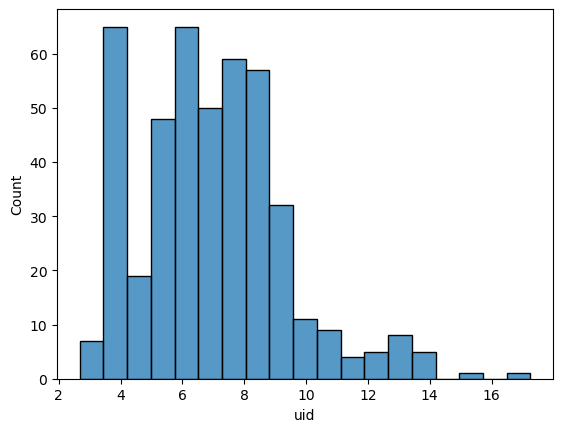

In [108]:
sns.histplot(data=fulldf, x='uid')

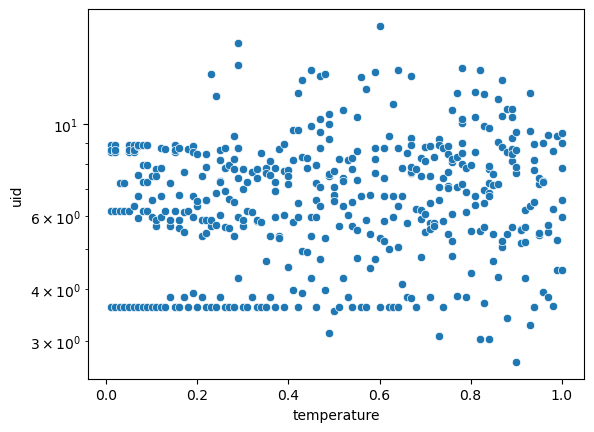

In [113]:
sns.scatterplot(data=fulldf, x='temperature', y='uid')
import matplotlib.pyplot as plt

### GPT-4V

In [16]:
data_path = "data/gpt_1101.txt"

In [17]:
with open(data_path, encoding = 'utf-8') as f:
    description = []
    for line in f:
        description.append(line)

gptdf = pd.DataFrame(description, columns=["description"])
gptdf['id'] = gptdf.index
gptdf['model'] = ['GPT-4(V)'] * gptdf.shape[0]

In [18]:
gptdf.head()

,description,id,model
0,"In a bright kitchen setting, a boy stands on a...",0,GPT-4(V)
1,"In a kitchen, a girl excitedly outstretches he...",1,GPT-4(V)
2,"A kitchen scene unfolds with a woman, presumab...",2,GPT-4(V)
3,"Within a kitchen, a woman stands by a window t...",3,GPT-4(V)
4,The kitchen atmosphere is evident with a count...,4,GPT-4(V)


In [19]:
gptdf['ttr'] = gptdf['description'].apply(word_counts)
gptdf['avg_freq'] = gptdf['description'].apply(avg_word_freq)
gptdf.head()

,description,id,model,ttr,avg_freq
0,"In a bright kitchen setting, a boy stands on a...",0,GPT-4(V),0.757576,5.584848
1,"In a kitchen, a girl excitedly outstretches he...",1,GPT-4(V),0.771930,5.821429
2,"A kitchen scene unfolds with a woman, presumab...",2,GPT-4(V),0.750000,5.696607
3,"Within a kitchen, a woman stands by a window t...",3,GPT-4(V),0.800000,5.707556
4,The kitchen atmosphere is evident with a count...,4,GPT-4(V),0.775510,5.640000


In [20]:
gptdf[['words', 'surps']] = gptdf['description'].apply(get_word_surp)
gptdf['uid'] = gptdf['surps'].apply(np.var)
gptdf['avg_info'] = gptdf['surps'].apply(np.mean)

In [94]:
gptdf.to_pickle("data/gpt_1102.pkl")

In [96]:
subset = ['description', 'ttr', 'avg_freq', 'avg_info', 'uid', 'model']
alldf = pd.concat([gptdf[subset], df[subset]])

In [47]:
color_pal

['#157361', '#91b8ad', '#ffffff', '#ffb68c', '#f56b16']

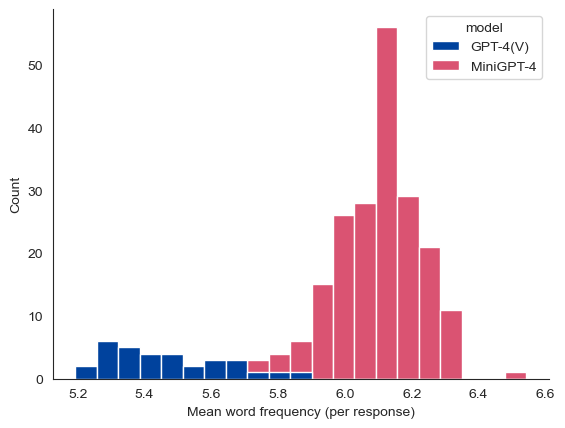

In [102]:
palette = {'GPT-4(V)': '#00429d', 
           'MiniGPT-4': '#da5372'}
kwargs = {'alpha':1}
sns.histplot(data=alldf, x='avg_freq', hue='model', palette=palette, **kwargs)
sns.despine()
plt.xlabel("Mean word frequency (per response)")
plt.ylabel("Count");
plt.savefig('wordfreq-hist.png')

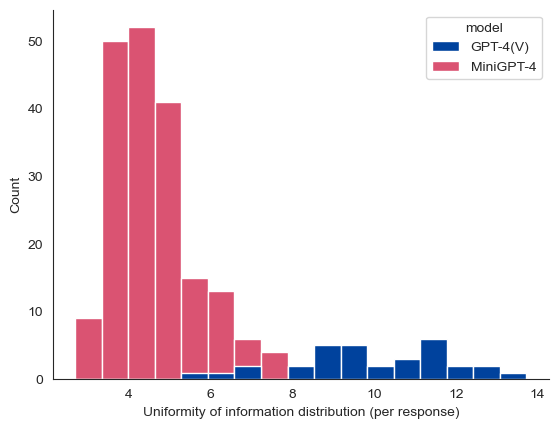

In [103]:
palette = {'GPT-4(V)': '#00429d', 
           'MiniGPT-4': '#da5372'}
kwargs = {'alpha':1}
sns.histplot(data=alldf, x='uid', hue='model', palette=palette, **kwargs)
sns.despine()
plt.xlabel("Uniformity of information distribution (per response)")
plt.ylabel("Count");
plt.savefig('uid-hist.png')

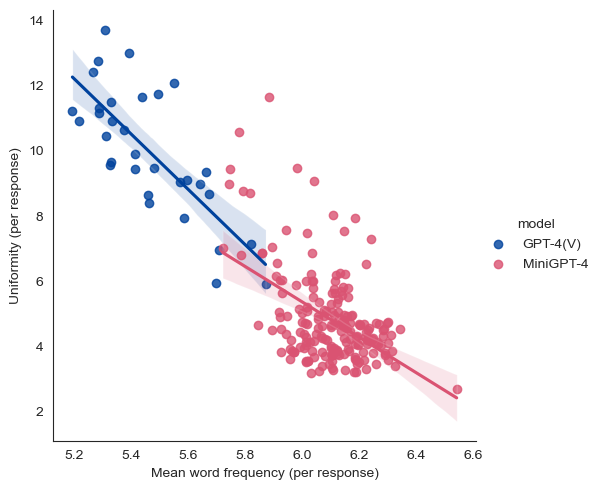

In [104]:
# palette = {'GPT-4(V)': '#00429d', 
#            'MiniGPT-4': '#da5372'}
# kwargs = {'alpha':1}
sns.lmplot(data=alldf, x='avg_freq', y='uid', hue='model', palette=palette)
sns.despine()
plt.xlabel("Mean word frequency (per response)")
plt.ylabel("Uniformity (per response)");
plt.savefig('relplot.png')

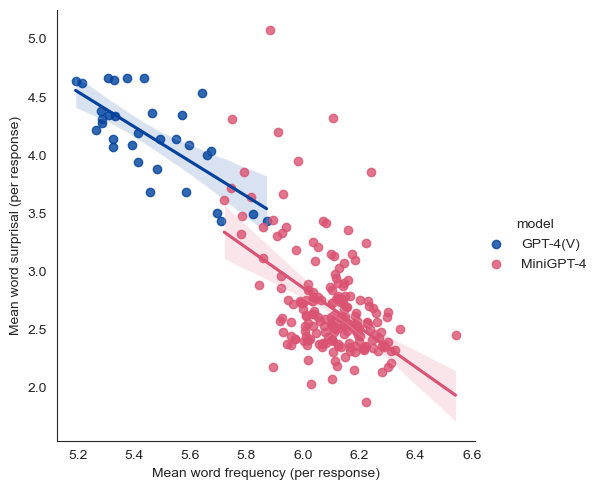

In [99]:
palette = {'GPT-4(V)': '#00429d', 
           'MiniGPT-4': '#da5372'}
# kwargs = {'alpha':1}
sns.lmplot(data=alldf, x='avg_freq', y='avg_info', hue='model', palette=palette)
sns.despine()
plt.xlabel("Mean word frequency (per response)")
plt.ylabel("Mean word surprisal (per response)");

In [ ]:
# palette = {'GPT-4(V)': '#00429d', 
#            'MiniGPT-4-low-temp': '#da5372',
#            'MiniGPT-4-high-temp': '#d98c79'}
# # kwargs = {'alpha':1}
# sns.lmplot(data=alldf, x='avg_freq', y='uid', hue='model', palette=palette)
# sns.despine()
# plt.xlabel("Mean word frequency (per response)")
# plt.ylabel("Uniformity (per response)");

In [73]:
# def label_temp(row):
#     if row['temperature'] < 1.01:
#         return 'MiniGPT-4-low-temp'
#     else:
#         return 'MiniGPT-4-high-temp'
# df['model'] = df.apply(lambda row: label_temp(row), axis=1)

#### Utterance-level

In [82]:
gptdf['sentences'] = gptdf['Description'].str.split('.')
gptdf

,Description,id,sentences
0,"In a bright kitchen setting, a boy stands on a...",0,"[In a bright kitchen setting, a boy stands on ..."
1,"In a kitchen, a girl excitedly outstretches he...",1,"[In a kitchen, a girl excitedly outstretches h..."
2,"A kitchen scene unfolds with a woman, presumab...",2,"[A kitchen scene unfolds with a woman, presuma..."
3,"Within a kitchen, a woman stands by a window t...",3,"[Within a kitchen, a woman stands by a window ..."
4,The kitchen atmosphere is evident with a count...,4,[The kitchen atmosphere is evident with a coun...
5,"Amidst the bright kitchen, the open cabinets r...",5,"[Amidst the bright kitchen, the open cabinets ..."
6,The focal point of this kitchen setting is the...,6,[The focal point of this kitchen setting is th...
7,A distinct feature of the kitchen scene is a p...,7,[A distinct feature of the kitchen scene is a ...
8,Emphasizing the interaction between the charac...,8,[Emphasizing the interaction between the chara...
9,The primary setting is a luminous kitchen wher...,9,[The primary setting is a luminous kitchen whe...


In [83]:
gptdf.iloc[9,:]['sentences']

['The primary setting is a luminous kitchen where the interactions of three characters stand out',
 ' A boy, elevated on a stool, goes for a cookie jar, an eager girl stands close, and a woman observes the scene, holding a dish',
 ' Surrounding details include a window, open cabinets, dishes, and a water puddle',
 '']

In [84]:
gptdf = gptdf.explode('sentences').reset_index(drop=True)
gptdf

,Description,id,sentences
0,"In a bright kitchen setting, a boy stands on a...",0,"In a bright kitchen setting, a boy stands on a..."
1,"In a bright kitchen setting, a boy stands on a...",0,A girl with outstretched hands appears excite...
2,"In a bright kitchen setting, a boy stands on a...",0,"A woman, likely their mother, observes the ch..."
3,"In a bright kitchen setting, a boy stands on a...",0,"Various kitchen elements, including open cabi..."
4,"In a bright kitchen setting, a boy stands on a...",0,
5,"In a kitchen, a girl excitedly outstretches he...",1,"In a kitchen, a girl excitedly outstretches he..."
6,"In a kitchen, a girl excitedly outstretches he...",1,Observing them is a woman standing near a sin...
7,"In a kitchen, a girl excitedly outstretches he...",1,"The room has open cabinets, a window showing ..."
8,"In a kitchen, a girl excitedly outstretches he...",1,
9,"A kitchen scene unfolds with a woman, presumab...",2,"A kitchen scene unfolds with a woman, presumab..."


In [85]:
gptdf = gptdf.loc[gptdf['sentences'] != ''].reset_index(drop=True)
gptdf

,Description,id,sentences
0,"In a bright kitchen setting, a boy stands on a...",0,"In a bright kitchen setting, a boy stands on a..."
1,"In a bright kitchen setting, a boy stands on a...",0,A girl with outstretched hands appears excite...
2,"In a bright kitchen setting, a boy stands on a...",0,"A woman, likely their mother, observes the ch..."
3,"In a bright kitchen setting, a boy stands on a...",0,"Various kitchen elements, including open cabi..."
4,"In a kitchen, a girl excitedly outstretches he...",1,"In a kitchen, a girl excitedly outstretches he..."
5,"In a kitchen, a girl excitedly outstretches he...",1,Observing them is a woman standing near a sin...
6,"In a kitchen, a girl excitedly outstretches he...",1,"The room has open cabinets, a window showing ..."
7,"A kitchen scene unfolds with a woman, presumab...",2,"A kitchen scene unfolds with a woman, presumab..."
8,"A kitchen scene unfolds with a woman, presumab...",2,"The boy, standing on a stool, reaches for a c..."
9,"A kitchen scene unfolds with a woman, presumab...",2,"Other elements like open cabinets, dishes, an..."


In [86]:
gptdf[['words', 'surps']] = gptdf['sentences'].apply(get_word_surp)

In [97]:
gptdf['uid'] = gptdf['surps'].apply(np.var)

In [100]:
gptdf['uid']

0      9.167739
1      7.926211
2      9.849084
3     14.976693
4      8.391807
5     14.671569
6      7.634666
7      5.281830
8      6.491142
9     13.232620
10     8.954195
11     9.438314
12    16.011692
13    10.923854
14     7.987653
15    14.309024
16     9.708506
17     7.022132
18     9.438818
19     9.041412
20     9.993086
21     8.321558
22     5.518325
23    11.069470
24    10.988599
25    11.881936
26    10.229916
27    11.564774
28     8.861424
29    13.341597
Name: uid, dtype: float64

<Axes: xlabel='uid', ylabel='Count'>

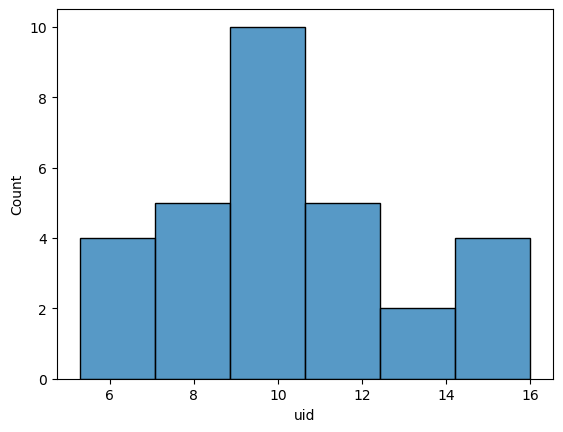

In [109]:
sns.histplot(data=gptdf, x='uid')

# MISC

In [29]:
sentences = [
    "The cat is on the mat.",
    "The cat is on the hat",
    "The cat is on the pizza",
    "The pizza is on the mat",
    "I told you that the cat is on the mat",
    "I told you the cat is on the mat",
]

df = pd.DataFrame(sentences, columns=['sent'])

In [30]:
df

,sent
0,The cat is on the mat.
1,The cat is on the hat
2,The cat is on the pizza
3,The pizza is on the mat
4,I told you that the cat is on the mat
5,I told you the cat is on the mat


In [35]:
get_word_surp(sentences[0])

0                 [The, Ġcat, Ġis, Ġon, Ġthe, Ġmat, .]
1    [3.276172161102295, 9.222101211547852, 2.46293...
dtype: object

In [36]:
df[['words', 'surps']] = df['sent'].apply(get_word_surp)

In [20]:
for word, surp in m.surprise(sentences[0])[0]:
    print(surp)

3.276172161102295
9.222101211547852
2.46293306350708
4.144979476928711
0.9611892700195312
7.2371673583984375
1.3514349460601807


In [37]:
df

,sent,words,surps
0,The cat is on the mat.,"[The, Ġcat, Ġis, Ġon, Ġthe, Ġmat, .]","[3.276172161102295, 9.222101211547852, 2.46293..."
1,The cat is on the hat,"[The, Ġcat, Ġis, Ġon, Ġthe, Ġhat]","[3.276172161102295, 9.222100257873535, 2.46292..."
2,The cat is on the pizza,"[The, Ġcat, Ġis, Ġon, Ġthe, Ġpizza]","[3.276172161102295, 9.222100257873535, 2.46292..."
3,The pizza is on the mat,"[The, Ġpizza, Ġis, Ġon, Ġthe, Ġmat]","[3.276172161102295, 10.859604835510254, 3.2117..."
4,I told you that the cat is on the mat,"[I, Ġtold, Ġyou, Ġthat, Ġthe, Ġcat, Ġis, Ġon, ...","[3.9977831840515137, 6.8563690185546875, 0.618..."
5,I told you the cat is on the mat,"[I, Ġtold, Ġyou, Ġthe, Ġcat, Ġis, Ġon, Ġthe, Ġ...","[3.9977831840515137, 6.8563690185546875, 0.618..."
